In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_04 import *

## Initial setup 

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [6]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [90]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [91]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback(accuracy)])

run.fit(3, learn)

train: [0.67691859375, tensor(0.8034)]
valid: [0.2977277099609375, tensor(0.9140)]
train: [0.29150998046875, tensor(0.9151)]
valid: [0.25547158203125, tensor(0.9229)]
train: [0.2347044140625, tensor(0.9315)]
valid: [0.195856787109375, tensor(0.9458)]


In [92]:
learn = create_learnner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.75573609375, tensor(0.8037)]
valid: [0.3527370361328125, tensor(0.9036)]
train: [0.349821953125, tensor(0.8996)]
valid: [0.2867052001953125, tensor(0.9215)]
train: [0.30019357421875, tensor(0.9126)]
valid: [0.2586145263671875, tensor(0.9267)]


In [93]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

## Annealing 

In [94]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs, self.losses = [],[]
    
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]["lr"])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_func):
        self.pname = pname
        self.sched_func = sched_func
        
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self):
        if self.in_train: self.set_param()

In [95]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

In [96]:
#export
def annealer(f):
    def _inner(start, end):
        return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos):
    return start + pos*(end-start)

In [97]:
f = sched_lin(1, 2)
f(0.3)

1.3

In [98]:
sched_lin(1, 2)

functools.partial(<function sched_lin at 0x106d59950>, 1, 2)

In [99]:
#export
@annealer
def sched_cos(start, end, pos):
    return start + (1 + math.cos(math.pi*(1-pos)))*(end-start)/2

@annealer
def sched_no(start, end, pos):
    return start

@annealer
def sched_exp(start, end, pos):
    return start * (end/start) ** pos

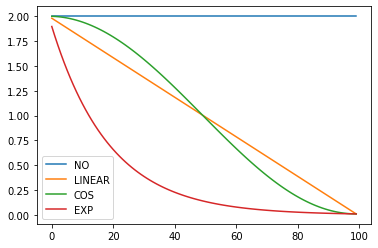

In [100]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01, 1, 100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(obj) for obj in p], label=t)
plt.legend()

In [101]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx])/(pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [102]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

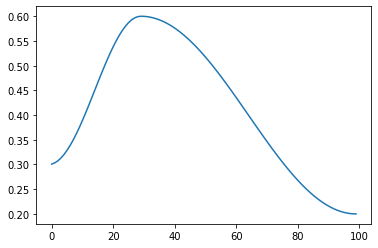

In [103]:
plt.plot(a, [sched(obj) for obj in p])

In [104]:
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        partial(ParamScheduler, "lr", sched)]

In [106]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [107]:
run.fit(3, learn)

train: [0.778722734375, tensor(0.7780)]
valid: [0.334439404296875, tensor(0.9032)]
train: [0.29565224609375, tensor(0.9136)]
valid: [0.2424967529296875, tensor(0.9326)]
train: [0.23684853515625, tensor(0.9313)]
valid: [0.2131978515625, tensor(0.9401)]


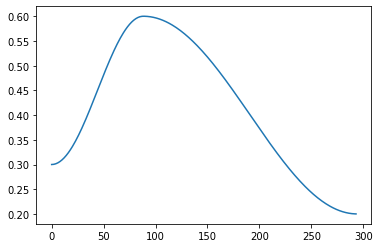

In [108]:
run.recorder.plot_lr()

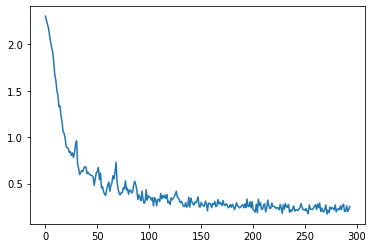

In [109]:
run.recorder.plot_loss()

## Export 

In [110]:
!python notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to exp/nb_05.py
